In [1]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
%matplotlib inline

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
multiplier = 50
min_tick = 0.25

In [3]:
#periods = [5, 10, 20]#, 40, 80] #, 160, 320] # 320] # number of periods for breakout rule
periods = [10]
ema_fast = 120 # number of periods for moving average filter
sl_atr = 1 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 15 # interval in minutes to be used to define volume candle

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

15894.085711955635

In [5]:
#vol_candles = group_by_time(contract, time_int)
vol_candles = group_by_volume(contract, avg_vol)
data = pd.DataFrame(vol_candles.close)
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()

In [6]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

In [7]:
def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).apply(np.floor)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
  

In [8]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

In [9]:
signals['value'] = signals['close'] * signals['signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

In [10]:
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, atr_periods)

In [11]:
signals.tail()

,close,signal,value,buy,sell,cum_signal,filter,atr
label,,,,,,,,
50522,2967.50,0.0,NaN,NaN,NaN,1.0,1.0,3.412500
50523,2969.25,1.0,2969.25,2969.25,NaN,1.0,1.0,3.412500
50524,2964.00,0.0,NaN,NaN,NaN,1.0,1.0,3.443750
50525,2961.50,0.0,NaN,NaN,NaN,1.0,1.0,3.375000
50526,2958.00,0.0,NaN,NaN,NaN,1.0,1.0,3.384375


In [11]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * sl_atr
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [12]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [13]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(4267.25, 3959.5, 8226.75)

In [14]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(16106, 12979, 0.5537562317345711)

In [15]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(29007.75, -20781.0, 1.395878446658005)

In [16]:
pnl_m.sort_values().head(20)

label
12805   -25.75
49861   -19.50
47563   -16.00
49851   -16.00
12898   -15.75
13502   -13.75
13331   -13.50
12933   -13.00
12947   -13.00
12910   -13.00
9501    -12.50
28037   -12.25
12871   -12.00
13487   -11.00
17752   -11.00
12938   -10.75
49119   -10.75
12995   -10.25
18019   -10.00
15275    -9.75
Name: pnl, dtype: float64

In [17]:
pnl_p.sort_values(ascending=False).head(20)

label
32566    35.00
49830    34.25
12894    21.00
46071    19.75
44971    18.75
13995    17.75
35044    17.50
9597     17.25
12896    17.00
35157    16.75
12802    16.25
50318    16.00
48116    15.75
9500     15.50
12900    15.50
48815    15.50
12892    14.50
12944    14.00
12866    13.25
34952    13.00
Name: pnl, dtype: float64

In [18]:
signals['date'] = vol_candles['date']

In [19]:
signals.set_index('date', inplace=True)

In [20]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-09-01,NaN,0.00
2019-09-02,2903.00,1.25
2019-09-03,2903.75,1.75
2019-09-04,2938.25,22.50
2019-09-05,2958.00,19.75


In [21]:
daily.head()

,close,pnl
date,,
2017-03-28,2331.5,0.0
2017-03-29,NaN,0.0
2017-03-30,NaN,0.0
2017-03-31,NaN,0.0
2017-04-01,NaN,0.0


In [22]:
daily['dollars'] = 0
daily.iloc[0,2] = 15000

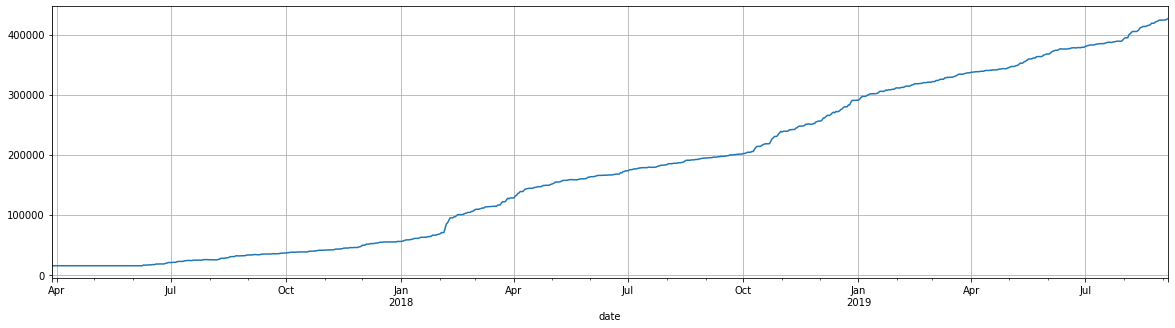

In [23]:
daily['dollars'] = 15000 + daily.pnl.cumsum() * multiplier
daily['return'] = daily.dollars.pct_change()
daily.dollars.plot(figsize=(20,5), grid=True);

In [24]:
daily['absolute'] = daily['pnl'] * multiplier/10000

In [25]:
perf_stats(daily['absolute'].iloc[40:])

Annual return          7.101142e+04
Cumulative returns     2.524238e+16
Annual volatility      1.327655e+00
Sharpe ratio           9.163765e+00
Calmar ratio           7.191030e+05
Stability              9.809293e-01
Max drawdown          -9.875000e-02
Omega ratio            2.225775e+01
Sortino ratio          8.085652e+01
Skew                   2.793266e+00
Kurtosis               1.280556e+01
Tail ratio             1.287308e+01
Daily value at risk   -1.189898e-01
dtype: float64

In [26]:
perf_stats(daily['return'].iloc[40:])

Annual return            1.691265
Cumulative returns      27.422500
Annual volatility        0.147060
Sharpe ratio             6.816352
Calmar ratio           117.513751
Stability                0.928124
Max drawdown            -0.014392
Omega ratio             17.151361
Sortino ratio           55.178765
Skew                     4.865846
Kurtosis                35.520550
Tail ratio              14.006090
Daily value at risk     -0.014550
dtype: float64

In [27]:
number_of_trades

4889

In [28]:
spread = min_tick * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

71037.17

In [29]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

891

In [30]:
trades_per_day = number_of_trades / days
trades_per_day

5.487093153759821

In [31]:
pnl_in_dollars = pnl*multiplier

In [32]:
cost_of_trades / (pnl_in_dollars)

0.17269801561977693

In [33]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(0.9585342883141157, 0.14438130178611577)

In [34]:
mean/std

6.638908753808534

In [35]:
#daily.to_pickle('nq_return.pickle')